In [4]:
%matplotlib inline

import cv2 as cv
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys

from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import find_peaks

# Add module path to sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import extract.image_parser as image_parser
import extract.img_processing as img_processing
import extract.txt_parser as txt_parser

/Users/jenny.folkesson/Code/serology-COVID19/array_analyzer


In [6]:
input_folder_ = '/Users/jenny.folkesson/Data/2020-01-15_plate4_AEP_Feb3_6mousesera/'

images = [file for file in os.listdir(input_folder_) if '.png' in file or '.tif' in file or '.jpg' in file]
wellimages = [file for file in images if re.match(r'[A-P][0-9]{1,2}', file)]
# sort by letter, then by number (with '10' coming AFTER '9')
wellimages.sort(key=lambda x: (x[0], int(x[1:-4])))
print(wellimages[84])

H7.png


In [7]:
xml_path = glob.glob(input_folder_ + '*.xml')
if len(xml_path) > 1 or not xml_path:
    raise IOError("Did not find unique xml")
xml_path = xml_path[0]

# parsing .xml
fiduc, spots, repl, params = txt_parser.create_xml_dict(xml_path)

In [8]:
# Load image, crop and background subtract
image_name = wellimages[84]
image = image_parser.read_gray_im(os.path.join(input_folder_, image_name))
props_array = txt_parser.create_array(
    params['rows'],
    params['columns'],
    dtype=object,
)
# finding center of well and cropping
cx, cy, r, well_mask = image_parser.find_well_border(
    image,
    segmethod='otsu',
    detmethod='region',
)
im_crop = image_parser.crop_image(image, cx, cy, r, border_=0)
# Remove background
background = img_processing.get_background(im_crop, fit_order=2)
im_crop = (im_crop / background * np.mean(background)).astype(np.uint8)

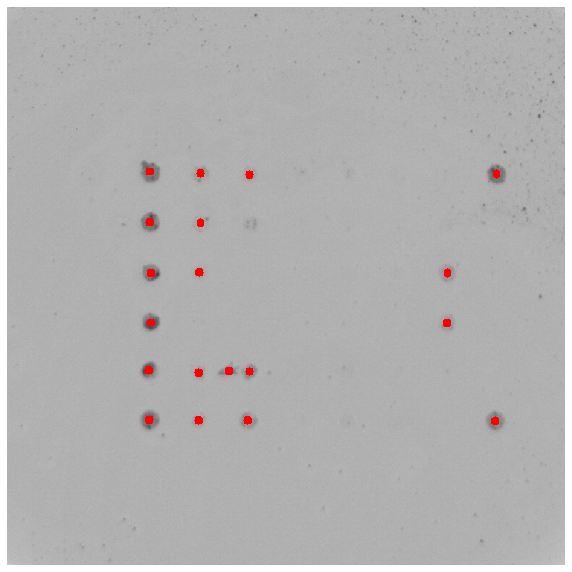

In [10]:
# Use OpenCV simple blob detector to find spots
nbr_grid_rows, nbr_grid_cols = props_array.shape
spot_coords = image_parser.get_spot_coords(
    im_crop,
    min_area=250,
    min_thresh=25,
)

im_roi = im_crop.copy()
im_roi = cv.cvtColor(im_roi, cv.COLOR_GRAY2RGB)
for c in range(spot_coords.shape[0]):
    coord = tuple(spot_coords[c, :].astype(np.int))
    cv.circle(im_roi, coord, 2, (255, 0, 0), 10)

plt.imshow(im_roi, cmap='gray')
plt.axis('off')
plt.rcParams['figure.figsize'] = [10, 15]
plt.show()

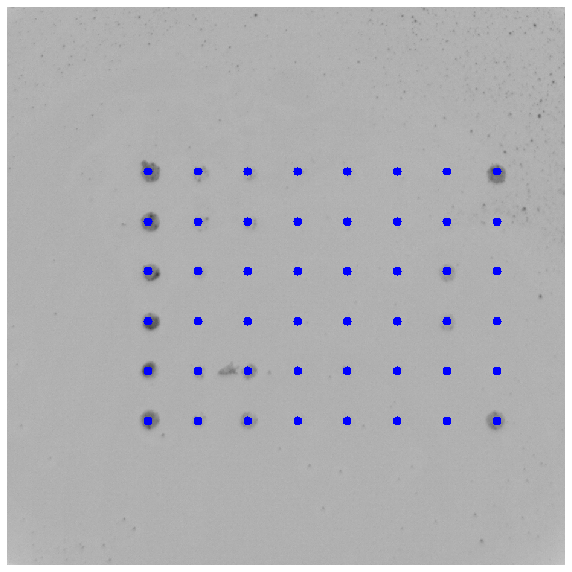

In [11]:
# Estimate initial grid location by taking intensity profiles in x and y and find peaks
mean_point, spot_dist = image_parser.grid_estimation(
    im=im_crop,
    spot_coords=spot_coords,
)
grid_coords = image_parser.create_reference_grid(
    mean_point=mean_point,
    nbr_grid_rows=nbr_grid_rows,
    nbr_grid_cols=nbr_grid_cols,
    spot_dist=spot_dist,
)

im_roi = im_crop.copy()
im_roi = cv.cvtColor(im_roi, cv.COLOR_GRAY2RGB)
for c in range(grid_coords.shape[0]):
    coord = tuple(grid_coords[c, :].astype(np.int))
    cv.circle(im_roi, coord, 2, (0, 0, 255), 10)
    
plt.imshow(im_roi, cmap='gray')
plt.axis('off')
plt.rcParams['figure.figsize'] = [10, 15]
plt.show()

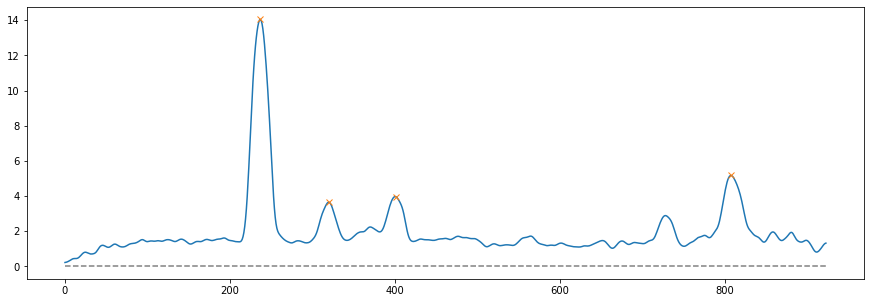

In [15]:
# Demonstration of how the spot location and distance was found
margin = 50 # Distance between peaks
prominence = 0.15 # Peak prominence

# Intensity profile
profile = np.mean(im_crop, axis=0) # in x
profile = profile.max() - profile
max_pos = int(np.where(profile == profile.max())[0])
# Make sure max is not due to leaving the center
add_margin = 0
half_margin = int(margin / 2)
if max_pos > len(profile) - half_margin:
    profile = profile[:-half_margin]
elif max_pos < half_margin:
    profile = profile[half_margin:]
    add_margin = half_margin
profile = gaussian_filter1d(profile, 3)
min_prom = profile.max() * prominence
peaks, _ = find_peaks(profile, prominence=min_prom, distance=50)

plt.plot(profile) 
plt.plot(peaks, profile[peaks], "x") 
plt.plot(np.zeros_like(profile), "--", color="gray")
plt.rcParams['figure.figsize'] = [2, 5]
plt.show()

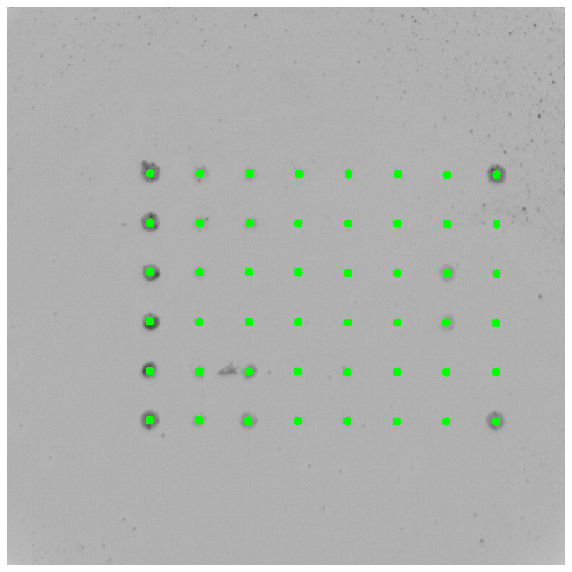

In [17]:
t_matrix = image_parser.icp(
    source=grid_coords,
    target=spot_coords,
)
grid_coords = np.squeeze(cv.transform(np.expand_dims(grid_coords, 0), t_matrix))

im_roi = im_crop.copy()
im_roi = cv.cvtColor(im_roi, cv.COLOR_GRAY2RGB)
for c in range(grid_coords.shape[0]):
    coord = tuple(grid_coords[c, :].astype(np.int))
    cv.circle(im_roi, coord, 2, (0, 255, 0), 10)
    
plt.imshow(im_roi, cmap='gray')
plt.axis('off')
plt.rcParams['figure.figsize'] = [10, 15]
plt.show()